# Analysing review data: using basic text mining to predict ratings of customer reviews for women’s clothing.

In this project we implement basic natural language processing and statistical analysis to rate customer reviews for an online women's clothing retailer. For each review we count the number of "positive" and "negative" words, and use this to calculate a suitable rating from 0-5. The categorisation of words with generally positive or negative connotations is based on results published in \[1\]. In order to test the effectiveness of our rating strategy, we plot graphs to measure the accuracy of each generated review rating compared with the original customer rating.

### Import the required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

## The customer review dataset
The dataset contains reviews of women’s clothes that are sold by a company online. In the file `WomensApparelReviews.csv` over 23000 reviews are given that are real but anonymized. The dataset contains the followin columns:

- **Product ID**: integer variable that refers to the specific item that is reviewed.
- **Age**: the reviewers age.
- **Title**: the title picked by the reviewer (some reviewers didn't pick any titles).
- **Review Text**: the body text of the review.
- **Rating**: the product score given by the customer from 1 (worst), to 5 (best).
- **Is it Recommended?**: the customers are asked whether or not they recommend the product. 1 means the product is recommended, 0 means not recommended.
- **Department**: the products are classified in different departments such as dress, top and ...


## Data cleaning

### Building a dataframe for customer reviews 
In order to extract statistical information from this dataset, we use pandas to read, clean and prepare the data for further analysis.

In [2]:
# Read product reviews from file into a panda dataframe
review_data=pd.read_csv('WomensApparelReviews.csv')

# Make columns names easier to read in python
review_data = review_data.rename(columns = {'Unnamed: 0': 'Review_ID', 
                                          'Is it Recommended?': 'is_recommended',
                                          'Product ID': 'Product_ID',
                                          'Review Text':'Review_Text'})

# Change the datatype of items in Title, Department and Review_Text columns to string, and items in the 
# is_recommended column to boolean
review_data = review_data.convert_dtypes()
review_data = review_data.astype({'is_recommended': 'bool'})
#review_data.dtypes

# Print the first few rows of the dataset
review_data.head()

,Review_ID,Product_ID,Age,Title,Review_Text,Rating,is_recommended,Department
0,0,767,33,<NA>,Absolutely wonderful - silky and sexy and comf...,4,True,Intimate
1,1,1080,34,<NA>,Love this dress! it's sooo pretty. i happene...,5,True,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,False,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,True,Bottoms
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,True,Tops


### Extracting list of positive and negetive words
In order to analyise occurances of positive and negative words in each customer review, we first need to unpack data from files 'positive-words.txt' and 'negative-words.txt'. Using basic text mining techniques, we compile two lists of strings, respectively containing collections of words with generally positive and negative connotations given in \[1\].

In [3]:
"""
The list of positive and negative words we use comes from the following two sources:
       
       Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
        Proceedings of the ACM SIGKDD International Conference on Knowledge 
        Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
        Washington, USA, 
       
       Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing 
        and Comparing Opinions on the Web." Proceedings of the 14th 
        International World Wide Web conference (WWW-2005), May 10-14, 
        2005, Chiba, Japan.
"""

# Read file containing list of positive words and use this to complile a python dictionary
with open('positive-words.txt','r') as positive_words_text:
    positive_words = positive_words_text.read().split()
    positive_words_start = positive_words.index('a+') 
    positive_words = positive_words[positive_words_start:]
    #positive_words_dict = dict.fromkeys(positive_words , 1)

# Do the same for the negative words
with open('negative-words.txt','r') as negative_words_text:
    negative_words = negative_words_text.read().split()
    negative_words_start = negative_words.index('2-faced') 
    negative_words = negative_words[negative_words_start:]
    #negative_words_dict = dict.fromkeys(negative_words , 1)

### Basic text mining functions
Firstly we define a function which counts word occurances in a body of text from a list of keywords. This will be used to calculate the positive and negative wordcount of each customer review.

In [4]:
def word_occurence_counter(text,keywords):
    """
    Counts occurences of words from @word_bank which appear in @text.

    Parameters:
        text (str): block of text with punctuation.
        
        keywords (list of strings): list of keywords.

    Returns:
        word_occurences (int): exact number of occurences of words from @keywords in @text

    """
    
    # raise error if inputs are not valid
    if type(text) != str:
        raise TypeError('First argument must be a string!')
    elif type(keywords) != list:
        raise TypeError('Second argument must be a list of strings!')
    else:
        pass
    
    for word in keywords:
        if type(word) != str:
            raise TypeError('Second argument must be a list of strings!')
        else:
            pass
        
    # remove line-break hyphens 
    text_without_linebreaks = re.sub(r'-\n([^ ]*)',r'\1\n',text)
    #        ^^^                ^^^ (triple quotes so you can use ' & " inside)
    #           ^              ^    (match start/end of string)
    #            ^    ^             (group 1)
    #             ^^^^              (group 1 is an optional single or double quote)
    #                  ^   ^        (group 2)
    #                   ^^^         (group 2 is anything - non-greedy)
    #                       ^^^     (then match whatever group 1 is)
    #dashes are different from hyphens - or shift-option - to get —
    
    ### REFERENCE 2
    # remove quotation marks
    text_without_quotations = re.sub(r''' (["'])(.*?)\1''', r' \2', text_without_linebreaks,flags = re.DOTALL)
    #                                                                               ^^^^^^  (matches . with everything including \n)
    #                                ^                      ^                               (raw string)
    #                                 ^^^              ^^^                                  (triple quotes so you can use ' & " inside)
    #                                     ^    ^                                            (group 1)
    #                                      ^^^^                                             (group 1 is an optional single or double quote)
    #                                           ^   ^                                       (group 2)
    #                                            ^^^                                        (group 2 is anything - non-greedy)
    #                                                ^^                                     (then match whatever group 1 is)
    ###
    
    # remove punctuation, excluding apostrophes or hypenated words
    text_without_punctuation = re.sub(r'[.,?!()]',' ',text_without_quotations)
    
    
    
    
    # split text into list of words 
    text_words = text_without_punctuation.split()
    
    # count word occurences
    word_occurences = 0
    for word in text_words:
        if word in keywords:
            word_occurences += 1
        else:
            pass
        
    return word_occurences

# alternatively one could also use re.findall(pattern, string, flags=0)...

# re.sub('''^(['"])(.*?)\\1$''', '\\2', str)
#        ^^^                ^^^ (triple quotes so you can use ' & " inside)
#           ^              ^    (match start/end of string)
#            ^    ^             (group 1)
#             ^^^^              (group 1 is an optional single or double quote)
#                  ^   ^        (group 2)
#                   ^^^         (group 2 is anything - non-greedy)
#                       ^^^     (then match whatever group 1 is)

Use this last function to define positive and negative word counters:

In [5]:
def wordcounter_pos(text,positive_wordbank):
    """
    Counts the number of positive words in @text.

    Parameters:
        text (str): body of text with punctuation 
        
        positive_words (list of strings): list of positive words

    Returns:
        wordcount_pos (int): number of positive words contained in the body of text

    """
    
    wordcount_pos = word_occurence_counter(text,positive_wordbank)
        
    return wordcount_pos

In [6]:
def wordcounter_neg(text,negative_wordbank):
    """
    Counts the number of negative words in @text.

    Parameters:
        text (str): body of text with punctuation 
        
        negative_words (list of strings): list of negative words

    Returns:
        wordcount_neg (int): number of negative words contained in the body of text

    """
    
    wordcount_neg = word_occurence_counter(text,negative_wordbank)
        
    return wordcount_neg

Lastly, we define a function which counts the number of words in a given body of text. This will be used to count the total number of words in each customer review.

In [7]:
def wordcounter(text):
    """
    Counts the total number of words in @text.

    Parameters:
        text (str): body of text with punctuation 

    Returns:
        wordcount (int): number of words contained in the body of text

    """
    # remove line-break hyphens 
    text_without_linebreaks = re.sub(r'-\n([^ ]*)',r'\1\n',text)
    #        ^^^                ^^^ (triple quotes so you can use ' & " inside)
    #           ^              ^    (match start/end of string)
    #            ^    ^             (group 1)
    #             ^^^^              (group 1 is an optional single or double quote)
    #                  ^   ^        (group 2)
    #                   ^^^         (group 2 is anything - non-greedy)
    #                       ^^^     (then match whatever group 1 is)
    #dashes are different from hyphens - or shift-option - to get —
    
    ### REFERENCE 2
    # remove quotation marks
    text_without_quotations = re.sub(r''' (["'])(.*?)\1''', r' \2', text_without_linebreaks,flags = re.DOTALL)
    #                                                                               ^^^^^^  (matches . with everything including \n)
    #                                ^                      ^                               (raw string)
    #                                 ^^^              ^^^                                  (triple quotes so you can use ' & " inside)
    #                                     ^    ^                                            (group 1)
    #                                      ^^^^                                             (group 1 is an optional single or double quote)
    #                                           ^   ^                                       (group 2)
    #                                            ^^^                                        (group 2 is anything - non-greedy)
    #                                                ^^                                     (then match whatever group 1 is)
    ###
    
    # remove punctuation, excluding apostrophes or hypenated words
    text_without_punctuation = re.sub(r'[.,?!()]',' ',text_without_quotations)
    
    
    # split text into list of words 
    text_words = text_without_punctuation.split()
    
    wordcount = len(text_words)
    
        
    return wordcount

## Statistical analysis

### Predicting customer ratings
Let us now implement the positive and negative wordcounters to construct an algorithm for generating customer ratings based on the review text. Based on the proportion of positive or negative words withing a customer review we will assign an integer between $1$ and $5$, with $1$ being the worst and $5$ the best.

In [8]:
def rating_generator(customer_review, positive_wordbank, negative_wordbank):
    """
    Calculates a predicted rating for a customer review based on the number of positive and negative words used.
    
    Parameters:
        customer_review (str): customer review for a bought item.
        
        positive_words (list of strings): list of positive words.
        
        negative_words (list of strings): list of negative words.

    Returns:
        predicted_rating (int): 
            integer between 1 and 5, with 1 being the worst and 5 the best, denoting the predicted customer
            rating for the given reviewed item.


    """
    
    # calculate proportion of positive/negative words in the customer review as a number between -1 and 1,
    # where 1 means all words are positive, -1 all words are negative and 0 means there are as many positive
    # words as there are negative.
    
    posneg_meas = (wordcounter_pos(customer_review,positive_wordbank) - wordcounter_neg(customer_review,negative_wordbank))/wordcounter(customer_review)
    
    r = 3 + posneg_meas*2
    
    if r - int(r) < 0.5:
        rating = int(r)
    elif r - int(r) >= 0.5:
        rating = int(r) + 1
        
    return rating

### Comparing predicted ratings with actual ratings 
Let us begin by adding a new column to our customer review dataframe for predicted ratings calculated using rating_generator. Then we will easily be able to plot a graph comparing predicted ratings with original customer ratings in order to test the effectiveness of our rating algorithm.

In [9]:
# Create a new column in containing the predicted customer ratings
review_data['Predicted_Rating'] = review_data['Review_Text'].apply(lambda customer_review: rating_generator(str(customer_review), positive_words, negative_words))

# Print first few rows of the dataframe
review_data.head()

,Review_ID,Product_ID,Age,Title,Review_Text,Rating,is_recommended,Department,Predicted_Rating
0,0,767,33,<NA>,Absolutely wonderful - silky and sexy and comf...,4,True,Intimate,4
1,1,1080,34,<NA>,Love this dress! it's sooo pretty. i happene...,5,True,Dresses,3
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,False,Dresses,3
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,True,Bottoms,3
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,True,Tops,3


Let us create a new column `Age_Category` in our dataframe with three possible categories: young (0-39 years), middle-aged (40-65 years) and old (>65 years). To do this, we first define a function which calculates the age category given age.

In [10]:
def age_category_finder(age):
    '''
    Calculates and age category given age of a person.
    
    Parameters:
        age (int): age of a person in years (0 being the smallest possible value.)
        
    Returns:
        age_category (str): one of three age categories: young (0-39 years), 
                            middle-aged (40-65 years) and old (>65 years.)
    '''
    
    if (0 <= age <= 39):
        age_category = 'Young'
    elif (40 <= age <= 65):
        age_category = 'Middle-aged'
    else:
        age_category = 'Old'
        
    return age_category

In [11]:
# Add a new column to store the age category. 
review_data['Age_Category'] = review_data['Age'].apply(lambda age: age_category_finder(int(age)))

# Print first few rows of the dataframe
review_data.head()

,Review_ID,Product_ID,Age,Title,Review_Text,Rating,is_recommended,Department,Predicted_Rating,Age_Category
0,0,767,33,<NA>,Absolutely wonderful - silky and sexy and comf...,4,True,Intimate,4,Young
1,1,1080,34,<NA>,Love this dress! it's sooo pretty. i happene...,5,True,Dresses,3,Young
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,False,Dresses,3,Middle-aged
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,True,Bottoms,3,Middle-aged
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,True,Tops,3,Middle-aged


Now let us plot the customer ratings against our predicted ratings for different age categories, clothing categories and responses to the question "Is it Recommended?"

In [79]:
# initiate dictionary of counters which will contain sum of differences between 
# customer ratings and predicted ratings and total number of reviews for each category and subcategory
rating_differences = {'Age_Category':Counter(),'Department':Counter(),'is_recommended':Counter()}
rating_counts = {'Age_Category':Counter(),'Department':Counter(),'is_recommended':Counter()}

#c = 0
for i in range(len(review_data)):
    
    rating_differences['Age_Category'][review_data.iloc[i]['Age_Category']] += np.abs(review_data.iloc[i]['Rating'] - review_data.iloc[i]['Predicted_Rating'])
    rating_counts['Age_Category'][review_data.iloc[i]['Age_Category']] += 1
    
    if type(review_data.iloc[i]['Department']) == str:
        rating_differences['Department'][review_data.iloc[i]['Department']] += np.abs(review_data.iloc[i]['Rating'] - review_data.iloc[i]['Predicted_Rating'])
        rating_counts['Department'][review_data.iloc[i]['Department']] += 1
    
    rating_differences['is_recommended'][review_data.iloc[i]['is_recommended']] += np.abs(review_data.iloc[i]['Rating'] - review_data.iloc[i]['Predicted_Rating'])
    rating_counts['is_recommended'][review_data.iloc[i]['is_recommended']] += 1
    
    #c+=1
    #if c>4:
    #    break

# initiate dictionary of counters which will contain average difference between 
# customer ratings and predicted ratings for each category and subcategory
rating_accuracy = {'Age_Category':Counter(),'Department':Counter(),'is_recommended':Counter()}

# calculate average difference between customer ratings and predicted ratings for each category and subcategory
for category in rating_differences:
    for subcategory in rating_differences[category]:
        
        rating_accuracy[category][subcategory] = rating_differences[category][subcategory] / rating_counts[category][subcategory]

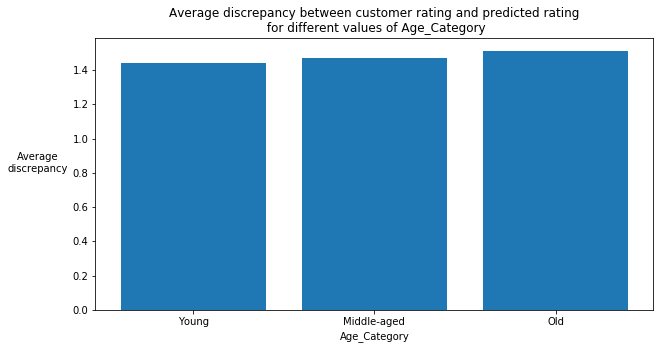

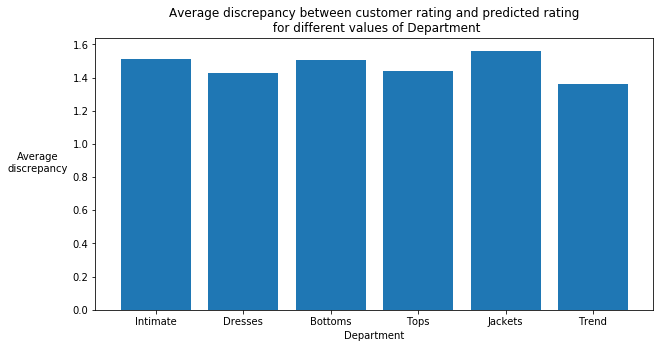

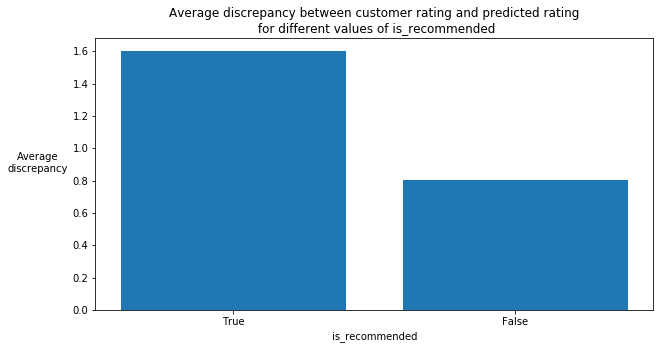

In [80]:
for category in rating_accuracy:
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    bar_pos = np.arange(len(rating_accuracy[category]))
    subcategory_labels = list(rating_accuracy[category].keys())
    #plt.xticks(bar_pos,list(subcategory_labels))
    plt.title('Average discrepancy between customer rating and predicted rating\n for different values of {}'.format(category))
    heights = []
    for subcategory in subcategory_labels:
        heights.append(rating_accuracy[category][subcategory])
        
    plt.bar(bar_pos, heights, tick_label = subcategory_labels)
    ax.set_xlabel('{}'.format(category),fontsize=10)
    ax.set_ylabel('Average\ndiscrepancy',rotation=0, fontsize=10, labelpad=35)
    plt.show()


### References

\[1\] http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

\[2\] https://stackoverflow.com/questions/40950791/remove-quotes-from-string-in-python/40950987 (stack exchange user dldnh)